# Quantum RNN para Coloração de Grafos

Partes do código do repo: [AgentANAKIN Q-RNN](https://github.com/AgentANAKIN/Quantum-Neural-Network "Quantum Neural Network"), que propõe uma rede neural simples quântica, possível de ser usada como base para maiores implementações.

Adaptações feitas para solucionar a coloração de grafos com essa implementação.

### Configurações 

Para configurar a rede base para uso no **IBM Quantum Experience**:

- Usar o API token como variável de ambiente;
- Salvar o token para não precisar reiniciar;
- De preferência usar uma virtualenv.

In [19]:
import os

from qiskit import Aer, ClassicalRegister, execute, QuantumCircuit, QuantumRegister, IBMQ
from qiskit.tools.monitor import job_monitor
from numpy import exp, array, random, dot

API_TOKEN = os.getenv('API_TOKEN')
IBMQ.save_account(API_TOKEN)

Credentials already present. Set overwrite=True to overwrite.


In [32]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

import time

### Métodos para medição

Com o código a baixo é possível "setar" os backends, ou para real, ou para simulado. O simulado é o mesmo utilzado nos códigos para coloração de grafos que eu implementei no outro notebook. Mas para esse aqui, eu coloquei para rodar em backends reais nas localidades disponíveis para minha conta no IBM Q Experience.

- Primeiro verifica se o backend escolhido está disponível;
- Depois são configurados os medidores;
- Por fim, é feita a conversão das medições;

In [20]:
def quniform(min, max):
    range = max - min
    qaddend = range * qmeasure('sim')
    qsum = qaddend + min
    return qsum

def qquniform(min, max):
    range = max - min
    qaddend = range * qmeasure('real')
    qsum = qaddend + min
    return qsum

def qmeasure(hardware):
    if (hardware == 'real'):
        qubits = 14
        #from qiskit.providers.ibmq import least_busy
        #backend = least_busy(IBMQ.backends())
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibmq_16_melbourne')
    else:
        qubits = 32
        backend = Aer.get_backend('qasm_simulator')
        
    q = QuantumRegister(qubits) 
    c = ClassicalRegister(qubits) 
    qc = QuantumCircuit(q, c) # initialize the circuit

    i = 0
    while i < qubits:
        qc.h(q[i]) # put all qubits into superposition states
        i = i + 1
   
    qc.measure(q, c) # collapse the superpositions and get random zeroes and ones
    job = execute(qc, backend=backend, shots=1)
    job_monitor(job)
    result = job.result()
    mraw = result.get_counts(qc)
    m = str(mraw)
    subtotal = 0
    for i in range(qubits):
        subtotal = subtotal + (int(m[i+2]) * 2**(i)) # convert each binary digit to its decimal value, but read left-to-right for simplicity
    multiplier = subtotal / (2**qubits) # convert the measurement to a value between 0 and 1
    
    return multiplier

In [21]:
class neural_network:
    def __init__(self):
        self.weights = []
        self.weights.append([qquniform(-1, 1)])
        self.weights.append([qquniform(-1, 1)])
        print("self.weights ",self.weights)

    def train(self, inputs, outputs, num):
        for iteration in range(num):
            output = self.think(inputs)
            error = outputs - output
            adjustment = 0.01*dot(inputs.T, error)
            self.weights += adjustment

    def think(self, inputs):
        return (dot(inputs, self.weights))


______________________________________________________________________________________________________________________

### Adaptações para implementação com um grafo
- Devem ser gerados conjuntos de entradas e saidas com a coloração para treino.
- Essas entradas serão _arrays_ que terão as informações dos vértices dos grafos.
- A saída é a coloração do grafo em um _array_ da mesma forma.

In [36]:
def timeit(func):
    def wrap(*args, **kwargs):
        time1 = time.time()
        ret = func(*args, **kwargs)
        time2 = time.time()
        print('{:s} function took {:.3f} ms'.format(func.__name__, (time2-time1)*1000.0))

        return ret
    return wrap

Acima um decorator simples para contar tempo. 

In [37]:
@timeit
def generate_G(n):
    G=nx.Graph()
    G.add_nodes_from(np.arange(0,n,1))
    elist=[(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0),(1,4,1.0),(4,0,1.0)]
    # tuple is (i,j,weight) where (i,j) is the edge
    G.add_weighted_edges_from(elist)
    return G

@timeit
def create_color_map(G):
    color_map = {}
    for node in G.nodes:
        available_colors = [True] * (len(G.nodes))
        for neighbor in G.neighbors(node):
              if neighbor in color_map:
                color = color_map[neighbor]
                available_colors[color] = False
        for color, available in enumerate(available_colors):
              if available:
                color_map[node] = color
                break
    return color_map

@timeit
def color_nodes(color_map):
    colors = ['','','','','']
    for i in range(len(color_map)):
        if color_map[i] == 2:
            colors[i] = 'r'
        elif color_map[i] == 1:
            colors[i] = 'g'
        elif color_map[i] == 0:
            colors[i] = 'b'
    return colors

@timeit
def plot_graph(G, color_map, colo):
    pos = nx.spring_layout(G)
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

O Grafo gerado

generate_G function took 2.751 ms
create_color_map function took 0.035 ms
color_nodes function took 0.008 ms
plot_graph function took 118.531 ms


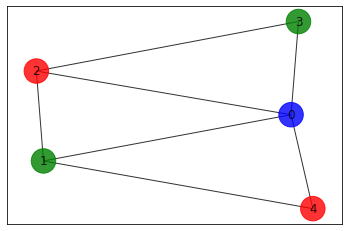

In [38]:
G = generate_G(5)
color_map = create_color_map(G)
colors = color_nodes(color_map)
plot_graph(G, color_map, colors)

O mapeamento de cores será usado como output

In [24]:
print(color_map)

{0: 0, 1: 1, 2: 2, 3: 1, 4: 2}


In [ ]:
neural_network = neural_network()
        
# training data
inputs = array([[[0,1],[0,2],[0,3],[1,2],[2,3],[1,4],[4,0]]])
outputs = array([[0, 1, 2, 1, 2]]).T

neural_network.train(inputs, outputs, 10000)

print(neural_network.think(array([[4, 0]])))
print(neural_network.think(array([[1, 4]])))
print(neural_network.think(array([[2, 3]])))
print(neural_network.think(array([[1, 2]])))
print(neural_network.think(array([[0, 3]])))
print(neural_network.think(array([[0, 2]])))
print(neural_network.think(array([[0, 1]])))

Com esse código é possível treinar uma rede simples com as entradas sendo os vértices do Grafo. O código deve ser escalado para poder treinar a rede com um número maior de grafos.

Obs.: Essa parte de trasnformar de volta os dados está dando mais trabalho. Mas consigo obter resultados com 1 grafo pelo menos na rede simples.

Estou pesquisando uma maneira de normalizar a entrada para que esse erro não ocorra quando tento escalar o código.

______________________________________________________________________________________________________________________

## Anotações sobre os outros assuntos

### Tabu Algorithm Search 

(Para a Prof. Karla sobre o que haviamos falado)

A ideia básica da pesquisa tabu é uma "mudança" ou "move" em uma topologia inicial, que resulta em uma solução de "vizinhança". Para cada topologia atual, são avaliadas todas as soluções vizinhas otimizando a função objetivo no roteamento e escolha o ideal.

O principal componente na pesquisa tabu é a definição de "mover". Suponha que tenhamos obtido um projeto de topologia (um projeto inicial pode ser obtido a partir de uma abordagem heurística simples). Então encontramos um ciclo de _l_-salto onde _l_ ≤ 8. A seleção do próximo salto, se o nó atual no ciclo for o _i_ésimo, segue a regra subsequente:

• Se _i_ for ímpar, selecione um link lógico de entrada e vá para o nó no lado oposto.

• Se _i_ for par, selecione qualquer nó que ainda não tenha estado no ciclo.

Quando um ciclo é encontrado, avalie o grau de cada nó. Se o grau de um nó for aumentado após a seleção do ciclo, remova as arestas supérfluas do gráfico.

### Métricas para medições Q

Na última reunião de quamtum que entrei lá no grupo, o Profissinal que falou era da área de Otimização com Computação Quântica. Ele falou sobre o quão importante é essa área de pesquisa para o Q-Advantage na IBM e falou sobre tudo que utiliza variações ou algorimos de variações tem ainda muito estudo a ser feito. 

O que foi discutido sobre as métricas foi que comparações com otimizadores clássicos são sempre um desafio. 

- Por exemplo na última rodada do algoritmo para a rede com grafos:
    - In queue 50.4s (O tempo que ficou na fila para ser executado)
    - Running 5.5s (O tempo que demorou para executar o algoritmo no computador)
    - Tempo de vadilação que não é fornecido +
    - O tempo total de 1m 2.8s
- Para os métodos clássicos:
    - generate_G function took 2.751 ms
    - create_color_map function took 0.035 ms
    - color_nodes function took 0.008 ms
    - plot_graph function took 118.531 ms
    - Tempo total de 0.121325 s (Ainda não é uma comparação fair)
    
Algumas infos a mais:

A arquitetura que está sendo usada (Para o prof. Serra)

![Q_arch](arch_Q.png)

Em outro anexo está o csv que consegui exportar as calibrações feitas para o circuito gerado para essa rede. 